# Первая CNN

Загрузим библиотеку `Pytorch`. Будем использовать

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Загрузим датасет `CIFAR10`. Объектов в тренировочной выборке у него 50 тысяч, а в тестовой 10 тысяч. Классов 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

Также поделим датасет на мини-батчи с помощью класса `Dataloader`

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True,
                                        download = True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 64,
                                           shuffle = True)

testset = torchvision.datasets.CIFAR10(root='./data', train = False,
                                        download = True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 64,
                                           shuffle = False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12870334.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Взглянем на изображения в нашем датасете

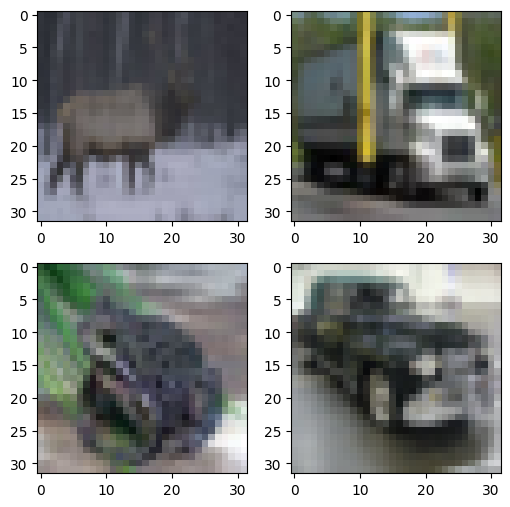

In [ ]:

fig = plt.figure(figsize=(6, 6))
rows = 2
columns = 2

i1 = np.random.randint(low=0, high=50000)
i2 = np.random.randint(low=0, high=50000)
i3 = np.random.randint(low=0, high=50000)
i4 = np.random.randint(low=0, high=50000)

fig.add_subplot(rows, columns, 1)
plt.imshow(train_loader.dataset.data[i1])

fig.add_subplot(rows, columns, 2)
plt.imshow(train_loader.dataset.data[i2])

fig.add_subplot(rows, columns, 3)
plt.imshow(train_loader.dataset.data[i3])

fig.add_subplot(rows, columns, 4)
plt.imshow(train_loader.dataset.data[i4])




Проверим, правильно ли разделились выборки на батчи:

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 32, 32])

Приступим к созданию нашей нейросети:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ConvNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 5)
    self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.fc1 = nn.Linear(128 * 6 * 6, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pooling(x)

    #print(x.shape)

    x = self.conv2(x)
    x = F.relu(x)
    x = self.pooling(x)

    x = x.view(-1, 6 * 6 * 128)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))

    x = self.fc4(x)

    return x


А теперь обучим, написанную нейросеть:

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
net = ConvNN().to(device)

loss_func = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for epoch in tqdm_notebook(range(10)):
  running_loss = 0.0

  for i, batch in enumerate(tqdm_notebook(train_loader)):

    X_batch, y_batch = batch

    y_pred = net(X_batch.to(device))

    loss = loss_func(y_pred, y_batch.to(device))
    loss.backward()
    optimizer.step()

    optimizer.zero_grad()

    running_loss += loss.item()

    if i % 2000 == 1999:
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

print('Модель завершила обучение')



<ipython-input-8-608a19c23f16>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-8-608a19c23f16>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Модель завершила обучение


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        y_pred = net(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 72 %
Accuracy of  bird : 59 %
Accuracy of   cat : 24 %
Accuracy of  deer : 36 %
Accuracy of   dog : 49 %
Accuracy of  frog : 64 %
Accuracy of horse : 67 %
Accuracy of  ship : 81 %
Accuracy of truck : 65 %
